In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bcn-clima/climaBCN.csv
/kaggle/input/info-stations/Informacio_Estacions_Bicing_2025.csv
/kaggle/input/2025-bike-availability-prediction/sample_submission_2025.csv
/kaggle/input/2025-bike-availability-prediction/metadata_sample_submission_2025.csv


In [2]:
import os

# Data entre años 2020 y 2023 se guarda en carpeta /training; 2024 en /test
i2m = list(zip(range(1,13), ['Gener','Febrer','Marc','Abril','Maig','Juny','Juliol','Agost','Setembre','Octubre','Novembre','Desembre']))
for year in range(2024, 2019, -1):
     for month, month_name in i2m:
         if (month > 5) and (year>2023): continue
         os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
         if year <= 2023:
             os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z' -o./data/training")
         else:
             os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z' -o./data/test")
         os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")

In [3]:
import pandas as pd
import os

training_path = "/kaggle/working/data/training"
# Leer path de todos los archivos de training y df de estaciones
file_list = [os.path.join(training_path, f) for f in os.listdir(training_path) if f.endswith(".csv")]
df_stations = pd.read_csv("/kaggle/input/info-stations/Informacio_Estacions_Bicing_2025.csv", dtype={"post_code": "str"})
df_weather = pd.read_csv("/kaggle/input/bcn-clima/climaBCN.csv")

# direcciones originales
#df_stations = pd.read_csv("/kaggle/input/stations/Informacio_Estacions_Bicing_2025.csv", dtype={"post_code": "str"})
#df_weather = pd.read_csv("/kaggle/input/clima-bcn/climaBCN.csv")

In [4]:
# Funcion usada para limpiar cada df de entrenamiento (se procesa un archivo a la vez para ahorrar memoria)
def construct_input(base, stations):
    df = base.merge(stations[['station_id', 'lat', 'lon', 'capacity']], on='station_id', how='left')
    df = df.dropna(subset=["num_docks_available", "lat", "lon", "capacity", "last_reported"])
    # Elimino registros donde 'last_reported' is 0; 'last_reported' == 0 --> NA
    df = df[~(df['last_reported'] == 0)]
    df['last_reported'] = pd.to_datetime(df['last_reported'], unit='s')
    df['percentage_docks_available'] = df['num_docks_available'] / df['capacity'] #target
    df["month"] = df["last_reported"].dt.month
    df["day"] = df["last_reported"].dt.day
    df["hour"] = df["last_reported"].dt.hour
    df["year"] = df["last_reported"].dt.year
    # Calculo de promedio de disponbilidad por hora por estacion
    df = df.sort_values("last_reported").groupby(["station_id","year","month","day","hour"])['percentage_docks_available'].mean().reset_index()
    return df[['station_id','hour','day','month','year','percentage_docks_available']]
    


In [5]:
# Leer, limpiar cada archivo y juntarlo luego en un solo df
df = pd.concat((construct_input(pd.read_csv(f), df_stations) for f in file_list), ignore_index=True)
# Ordenar el df para asegurar que los calculos de shift() se apliquen correctamente. El concat depende de como se guarden en file_list, en kaggle no siempre se guardan en orden.
df = df.sort_values(by = ['year','month','day'])

<ipython-input-5-d1820e3642a2>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((construct_input(pd.read_csv(f), df_stations) for f in file_list), ignore_index=True)
<ipython-input-5-d1820e3642a2>:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((construct_input(pd.read_csv(f), df_stations) for f in file_list), ignore_index=True)


### Exploraciones

### Evolucion a lo largo del tiempo

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

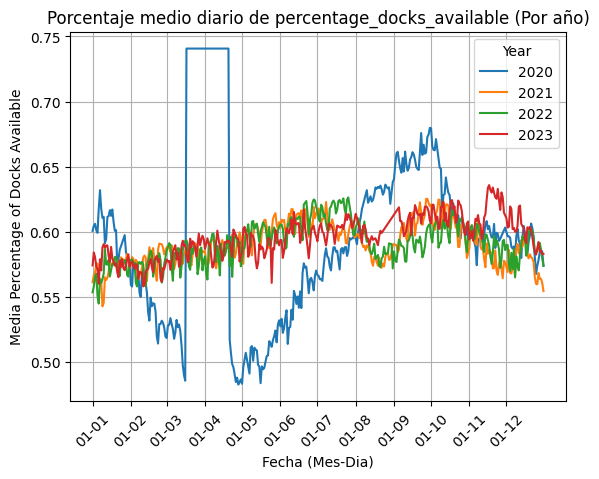

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular el porcentaje medio por dia 
daily_mean = df[df['year'] > 2019].groupby(['year', 'month', 'day'])['percentage_docks_available'].mean().reset_index()

# Crear col. en formato fecha para el grafico. (el año es irrelevante, solo sirve para hacer la comparacion mes-dia)
daily_mean['date'] = pd.to_datetime(daily_mean[['month', 'day']].assign(year=2000))

# Plot de la evolucion a lo largo del tiempo
sns.lineplot(data= daily_mean, x='date', y='percentage_docks_available', hue='year', palette='tab10')

# x-axis: Muestra solo el primer dia de cada mes
xticks_dates = pd.date_range("2000-01-01", "2000-12-31", freq="MS")  # "MS" = Month Start
plt.xticks(xticks_dates, [d.strftime('%d-%m') for d in xticks_dates], rotation=45)

# Formatting the plot
plt.title('Porcentaje medio diario de percentage_docks_available (Por año)')
plt.xlabel('Fecha (Mes-Dia)')
plt.ylabel('Media Percentage of Docks Available')
plt.xticks(rotation=45) 
plt.legend(title='Year')
plt.grid(True)
plt.show()

### Distribucion de la disponibilidad mensual

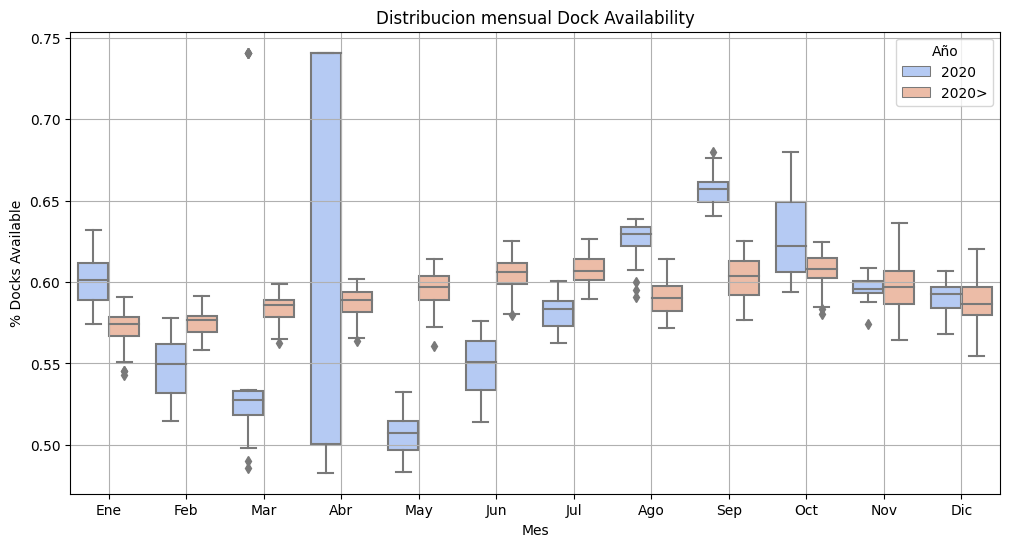

In [7]:
# Calcular el porcentaje medio por dia 
daily_mean = df[df['year'] > 2019].groupby(['year', 'month', 'day'])['percentage_docks_available'].mean().reset_index()
daily_mean['year_category'] = daily_mean['year'].apply(lambda x: '2020' if x < 2021 else '2020>')

# Boxplot distribucion mensual
plt.figure(figsize=(12, 6))
sns.boxplot(data=daily_mean, x='month', y='percentage_docks_available', hue='year_category', palette='coolwarm')

plt.title('Distribucion mensual Dock Availability')
plt.xlabel('Mes')
plt.ylabel('% Docks Available')
plt.xticks(range(12), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend(title='Año')
plt.grid(True)
plt.show()

### Disponibilidad por hora y mes

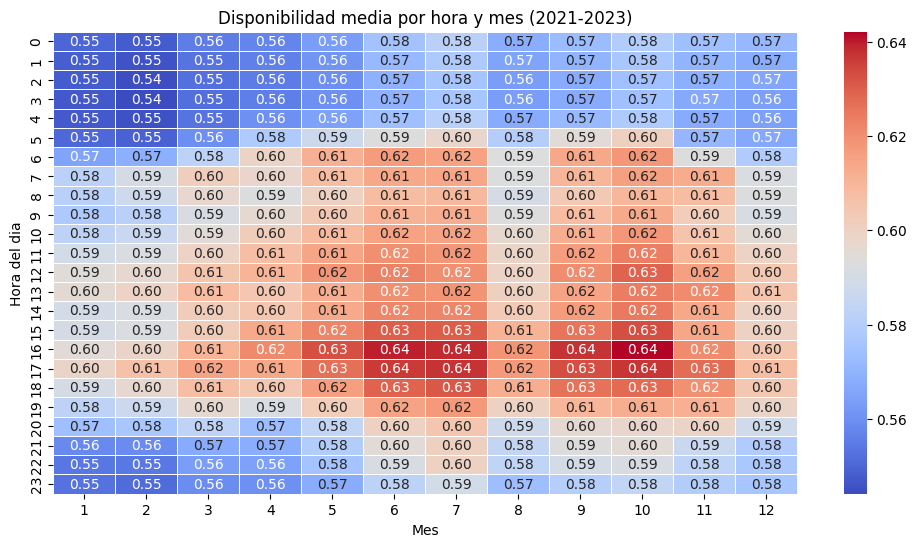

In [8]:
# Media 'percentage_docks_available' (solo incluimos >2020)
heatmap_hora_mes = df[df['year'] > 2020].groupby(['hour', 'month'])['percentage_docks_available'].mean().unstack()
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_hora_mes, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Disponibilidad media por hora y mes (2021-2023)')
plt.xlabel('Mes')
plt.ylabel('Hora del dia')
plt.show()

In [9]:
heatmap_hora_mes.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
hour,,,,,,,,,,,,
0,0.550232,0.547915,0.555381,0.557506,0.563312,0.575031,0.581308,0.567982,0.572698,0.579101,0.573641,0.571423
1,0.548198,0.545931,0.553260,0.556222,0.561162,0.571734,0.577954,0.565329,0.569837,0.576356,0.570130,0.567783
2,0.547860,0.544867,0.552274,0.555095,0.559577,0.569326,0.575832,0.563383,0.567398,0.574293,0.568570,0.566142
3,0.547236,0.544186,0.551836,0.555813,0.559881,0.569401,0.576221,0.563309,0.567465,0.574105,0.567077,0.564402
4,0.547504,0.545344,0.553204,0.560139,0.564699,0.573692,0.581102,0.567267,0.571965,0.578330,0.567134,0.564436


# Modelos y predicciones

In [10]:
# Disponibilidad en las 4 horas anteriores
for i in range(1, 5):  # Creamos ctx-1 hasta ctx-4
    df[f"ctx-{i}"] = df.groupby("station_id")["percentage_docks_available"].shift(i)

In [11]:
df = df.dropna(subset=["ctx-1", "ctx-2", "ctx-3", "ctx-4"])

In [12]:
# Variable binaria indicando si habia confinamiento (=1) o no (=0)
lockdown_start = pd.to_datetime('2020-03-15')
lockdown_end = pd.to_datetime('2020-06-21')

# Creamos temporalmente una columna en formato "date" para facilitar la definicion de la variable
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
# 1 si se encuentra en el rango definido
df['lockdown'] = df['date'].between(lockdown_start, lockdown_end).astype(int)
df = df.drop('date', axis=1)

In [13]:
df.loc[df['station_id'] == 1].head(20)


,station_id,hour,day,month,year,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,lockdown
4,1.0,2,1,1,2020,0.338768,0.385870,0.449275,0.481884,0.500000,0
5,1.0,3,1,1,2020,0.277174,0.338768,0.385870,0.449275,0.481884,0
6,1.0,4,1,1,2020,0.356884,0.277174,0.338768,0.385870,0.449275,0
7,1.0,5,1,1,2020,0.291667,0.356884,0.277174,0.338768,0.385870,0
8,1.0,6,1,1,2020,0.228261,0.291667,0.356884,0.277174,0.338768,0
9,1.0,7,1,1,2020,0.230072,0.228261,0.291667,0.356884,0.277174,0
10,1.0,8,1,1,2020,0.242754,0.230072,0.228261,0.291667,0.356884,0
11,1.0,9,1,1,2020,0.257246,0.242754,0.230072,0.228261,0.291667,0
12,1.0,10,1,1,2020,0.335145,0.257246,0.242754,0.230072,0.228261,0
13,1.0,11,1,1,2020,0.329710,0.335145,0.257246,0.242754,0.230072,0


In [14]:
display(df.loc[(df['station_id'] == 5) & (df['year'] == 2020) & (df['month'] == 4)].head())
display(df.loc[(df['station_id'] == 5) & (df['year'] == 2021) & (df['month'] == 4)].head())

,station_id,hour,day,month,year,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,lockdown
4493193,5.0,7,22,4,2020,0.307692,0.538462,0.538462,0.538462,0.523504,1
4493194,5.0,8,22,4,2020,0.307692,0.307692,0.538462,0.538462,0.538462,1
4493195,5.0,9,22,4,2020,0.307692,0.307692,0.307692,0.538462,0.538462,1
4493196,5.0,10,22,4,2020,0.461538,0.307692,0.307692,0.307692,0.538462,1
4493197,5.0,11,22,4,2020,0.538462,0.461538,0.307692,0.307692,0.307692,1


,station_id,hour,day,month,year,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,lockdown
13943136,5.0,0,1,4,2021,0.128205,0.128205,0.128205,0.128205,0.142191,0
13943137,5.0,1,1,4,2021,0.128205,0.128205,0.128205,0.128205,0.128205,0
13943138,5.0,2,1,4,2021,0.128205,0.128205,0.128205,0.128205,0.128205,0
13943139,5.0,3,1,4,2021,0.126068,0.128205,0.128205,0.128205,0.128205,0
13943140,5.0,4,1,4,2021,0.098291,0.126068,0.128205,0.128205,0.128205,0


In [15]:
# Dividir en características (X) y variable objetivo (y)
X = df[["station_id","hour","month","day","year","ctx-4", "ctx-3", "ctx-2", "ctx-1"]]
# Anadir temperatura y presion media
X = X.merge(df_weather[['year','month','day','TM','HRM']], on=['year','month','day'], how='left') 
X = X.drop('year', axis=1)
y = df["percentage_docks_available"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, random_state=42)

print(f"Datos de entrenamiento: {X_train.shape[0]} registros")
print(f"Datos de prueba: {X_test.shape[0]} registros")

Datos de entrenamiento: 15724266 registros
Datos de prueba: 655178 registros


In [16]:
X.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,station_id,hour,month,day,ctx-4,ctx-3,ctx-2,ctx-1,TM,HRM
0,32.0,7,11,15,1.533333,1.533333,1.484583,1.533333,NaN,NaN
1,1.0,2,1,1,0.500000,0.481884,0.449275,0.385870,8.375,77.25
2,1.0,3,1,1,0.481884,0.449275,0.385870,0.338768,8.375,77.25
3,1.0,4,1,1,0.449275,0.385870,0.338768,0.277174,8.375,77.25
4,1.0,5,1,1,0.385870,0.338768,0.277174,0.356884,8.375,77.25


In [17]:
# Entrenamiento
from xgboost import XGBRegressor

# Crear el modelo de XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,                  
    random_state=42
)

# Entrenamos el modelo
xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [18]:
# Evaluación del modelo

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Evaluamos el rendimiento en el conjunto de test
y_pred_rf = xgb_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"XGBoost - MSE: {mse_rf:.4f}, R^2: {r2_rf:.4f}")

XGBoost - MSE: 0.0101, R^2: 0.8687


In [19]:
# Test output

X_test = pd.read_csv('/kaggle/input/2025-bike-availability-prediction/metadata_sample_submission_2025.csv',index_col=0)
X_test['year'] = 2024
X_test = X_test.iloc[:, [0, 3, 1, 2, 8, 4, 5, 6, 7]]
X_test = X_test.merge(df_weather[['year','month','day','TM','HRM']], on=['year','month','day'], how='left')
X_test = X_test.drop('year', axis=1)
y_pred = xgb_model.predict(X_test)

df_output = pd.DataFrame(y_pred)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']

df_output.to_csv('submission.csv',index=False)